# Read raw data from Wikipedia page

In [123]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests

In [124]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(url)
soup  = BeautifulSoup(response.text, 'html.parser')
table = soup.find("table")

l = []
for tr in table.find_all('tr'):
    td = tr.find_all('td')
    if (len(td) == 3):
      row = [tr.text.split('\n')[0] for tr in td]
      l.append(row)
    
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])

In [125]:
print("Dataframe shape:", df.shape)
df.head(12)

Dataframe shape: (288, 3)


,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


# Data Preparation
## Clean not assigned Borough

In [126]:
df = df[df["Borough"] != "Not assigned"]
print("Dataframe shape:", df.shape)
df.head(12)

Dataframe shape: (211, 3)


,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


## Fill not assigned Neighbourhood

In [127]:

df["Neighbourhood"] = np.where(df["Neighbourhood"] == "Not assigned", df["Borough"], df["Neighbourhood"])

df.head(12)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


## Add geographical coordinates

In [7]:
!conda config --add channels conda-forge
!conda install geocoder

Solving environment: done

# All requested packages already installed.



In [128]:
import geocoder

In [129]:
def get_coord(row):
  coord = None
  while(coord is None):
      a = geocoder.arcgis('{}, Toronto, {}, {}'.format(row['PostalCode'], row['Borough'], row['Neighbourhood']))
      coord = a.latlng
  return coord

def get_latitude(row):
    return get_coord(row)[0]

def get_longitude(row):
    return get_coord(row)[1]

In [130]:
df['Latitude'] = df.apply(get_latitude, axis=1)
df['Longitude'] = df.apply(get_longitude, axis=1)

df.head(12)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.752440,-79.329271
3,M4A,North York,Victoria Village,43.730421,-79.313320
4,M5A,Downtown Toronto,Harbourfront,43.655120,-79.362640
5,M5A,Downtown Toronto,Regent Park,43.660690,-79.360310
6,M6A,North York,Lawrence Heights,43.723570,-79.437110
7,M6A,North York,Lawrence Manor,43.714846,-79.450068
8,M7A,Queen's Park,Queen's Park,43.661290,-79.390040
10,M9A,Etobicoke,Islington Avenue,43.663163,-79.531490
11,M1B,Scarborough,Rouge,43.811525,-79.195517
12,M1B,Scarborough,Malvern,43.797381,-79.236061


### Now let's verify coordinates. They are all different and distributed among boroughs

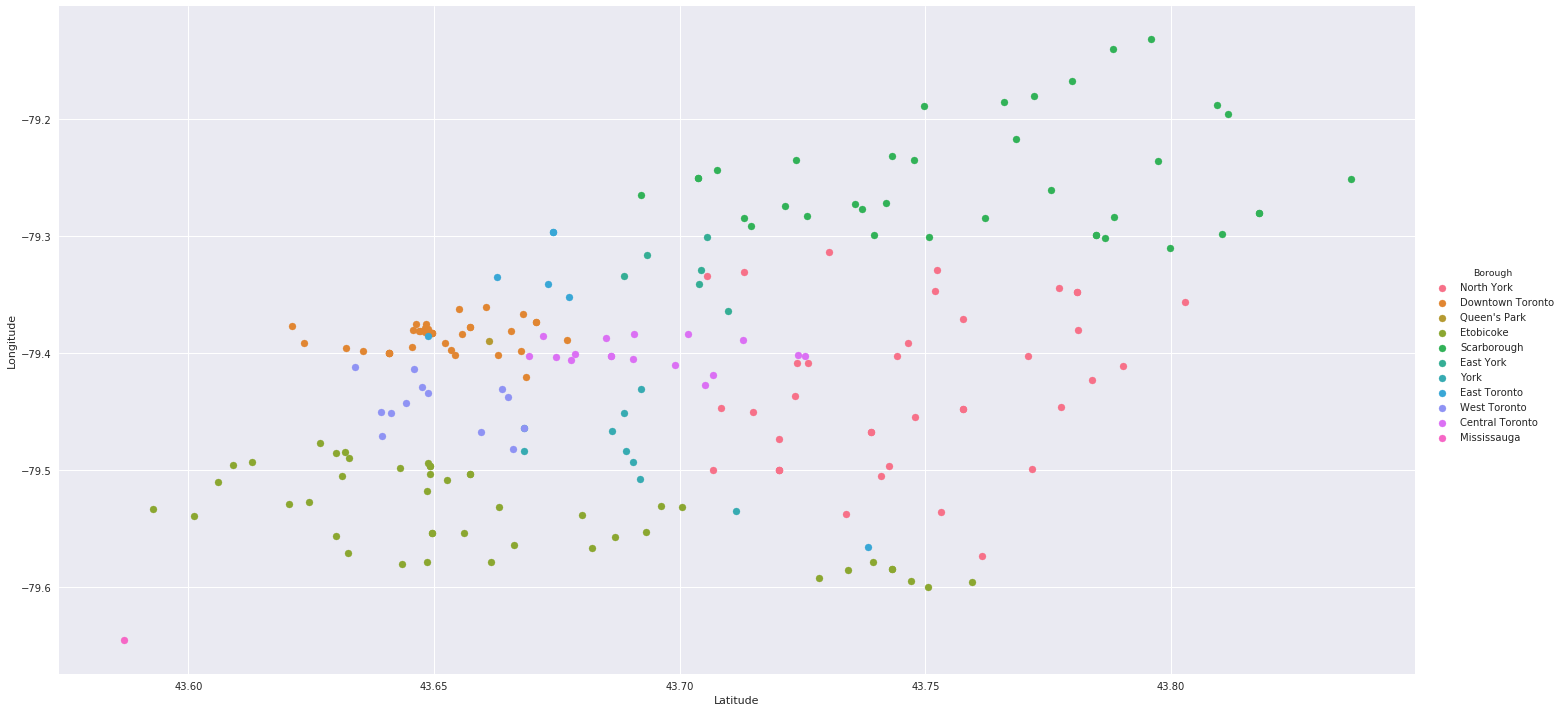

In [131]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
fg = sns.FacetGrid(data=df, hue='Borough', aspect=2, size = 10)
fg.map(pyplot.scatter, 'Latitude', 'Longitude').add_legend()

# Clustering Neighborhoods

In [44]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.



In [134]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import random
rnd = lambda: random.randint(0,255)
rnd_color = lambda: colors.rgb2hex(cm.rainbow(r()))

In [135]:
neighbourhoods = list(df['Neighbourhood'].unique())
nn.index('Harbourfront')
len(neighbourhoods)

209

## Show map colored by Borough

In [144]:
neighbourhoods = list(df2['Neighbourhood'].unique())
colors_array = cm.rainbow(np.linspace(0, 1, len(neighbourhoods)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow_dark = [colors.rgb2hex(i) for i in colors_array / 3]

latitude = df['Latitude'].mean()
longitude = df['Longitude'].mean()
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow_dark[neighbourhoods.index(neighborhood)],
        fill=True,
        fill_color=rainbow[neighbourhoods.index(neighborhood)],
        fill_opacity=0.9,
        parse_html=False).add_to(map_toronto)  

map_toronto

## Fit for 5 clusters

In [138]:
from sklearn.cluster import KMeans
n_clusters = 5
coordinates_df = df[['Latitude','Longitude']]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coordinates_df)
cluster_df = df.copy()
cluster_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [139]:
cluster_df.head(12)

,Cluster Labels,PostalCode,Borough,Neighbourhood,Latitude,Longitude
2,2,M3A,North York,Parkwoods,43.752440,-79.329271
3,2,M4A,North York,Victoria Village,43.730421,-79.313320
4,0,M5A,Downtown Toronto,Harbourfront,43.655120,-79.362640
5,0,M5A,Downtown Toronto,Regent Park,43.660690,-79.360310
6,4,M6A,North York,Lawrence Heights,43.723570,-79.437110
7,4,M6A,North York,Lawrence Manor,43.714846,-79.450068
8,0,M7A,Queen's Park,Queen's Park,43.661290,-79.390040
10,1,M9A,Etobicoke,Islington Avenue,43.663163,-79.531490
11,2,M1B,Scarborough,Rouge,43.811525,-79.195517
12,2,M1B,Scarborough,Malvern,43.797381,-79.236061


## Show map colored by Clusters

In [145]:
colors_array_cluster = cm.rainbow(np.linspace(0, 1, n_clusters))
rainbow_cluster = [colors.rgb2hex(i) for i in colors_array_cluster]
rainbow_cluster_dark = [colors.rgb2hex(i) for i in colors_array_cluster / 3]

map_toronto_clustered = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood, cluster in zip(cluster_df['Latitude'], cluster_df['Longitude'], cluster_df['Borough'], cluster_df['Neighbourhood'], cluster_df['Cluster Labels']):
    label = '#{}: {}, {}'.format(cluster, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow_cluster_dark[cluster-1],
        fill=True,
        fill_color=rainbow_cluster[cluster-1],
        fill_opacity=0.9,
        parse_html=False).add_to(map_toronto_clustered)  

map_toronto_clustered